In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

patient_data_path = '/home/tstrebel/repos/umich-mads-capstone-project/assets/rsna-patient-details.csv'

In [2]:
df = pd.read_csv(patient_data_path)

df['age_group'] = pd.cut(df.patient_age, 
                                  [0, 1, 5, 12, 18, 44, 64, 79, np.inf], 
                                  labels=['Infant 1 year-old', 
                                          'preschool (2-5)', 
                                          'Child (6-12)', 
                                          'Adolescent (13-18)', 
                                          'Adult (19-44)', 
                                          'Middle age (45-64)', 
                                          'Aged (65-79)', 'Aged 80+'])
df['view_position'] = df['view_position'].map({'AP':'Anterior/Posterior', 'PA':'Posterior/Anterior'})

df.head()

,index,patient_id,patient_age,patient_sex,view_position,class,target,split,rsna_baseline_proba,rsna_densenet_proba,age_group
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,NaN,No Lung Opacity / Not Normal,0,train,0.199968,0.272411,Middle age (45-64)
1,1,000924cf-0f8d-42bd-9158-1af53881a557,19,F,NaN,Normal,0,train,0.156917,0.031587,Adult (19-44)
2,2,000db696-cf54-4385-b10b-6b16fbb3f985,25,F,NaN,Lung Opacity,1,train,0.688685,0.698994,Adult (19-44)
3,3,000fe35a-2649-43d4-b027-e67796d412e0,40,M,NaN,Lung Opacity,1,train,0.943956,0.984925,Adult (19-44)
4,4,001031d9-f904-4a23-b3e5-2c088acd19c6,57,M,NaN,Lung Opacity,1,train,0.374111,0.407364,Middle age (45-64)


In [3]:
def get_y_test_y_score(proba_col_name=None) -> None:
    if not proba_col_name:
        raise Exception('Must specify probal_col_name!')
    df_test = df[df['split']=='test']
    return df_test.target, df_test[proba_col_name]

def print_metrics(ytest, y_score, model_name):
    # Threshold tuning
    precision, recall, thresh = metrics.precision_recall_curve(y_test, y_score)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    y_pred = (y_score >= thresh[ix]).astype(int)

    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_score)
    avg_precision = metrics.average_precision_score(y_test, y_score)
    
    print('Model:\t\t{}'.format(model_name))
    print('Best Threshold:\t\t{:.3f}'.format(thresh[ix]))
    print('Precision:\t\t{:.3f}'.format(precision))
    print('Recall:\t\t\t{:.3f}'.format(recall))
    print('F1:\t\t\t{:.3f}'.format(f1))
    print('ROC AUC:\t\t{:.3f}'.format(roc_auc))
    print('Average Precision:\t{:.3f}'.format(avg_precision))

In [4]:
y_test, y_score = get_y_test_y_score(proba_col_name='rsna_baseline_proba')
print_metrics(y_test, y_score, model_name='RSNA Baseline Model')

Model:		RSNA Baseline Model
Best Threshold:		0.347
Precision:		0.605
Recall:			0.661
F1:			0.632
ROC AUC:		0.861
Average Precision:	0.656


In [5]:
y_test, y_score = get_y_test_y_score(proba_col_name='rsna_densenet_proba')
print_metrics(y_test, y_score, model_name='RSNA w/Transfer Learning')

Model:		RSNA w/Transfer Learning
Best Threshold:		0.406
Precision:		0.616
Recall:			0.686
F1:			0.649
ROC AUC:		0.881
Average Precision:	0.698


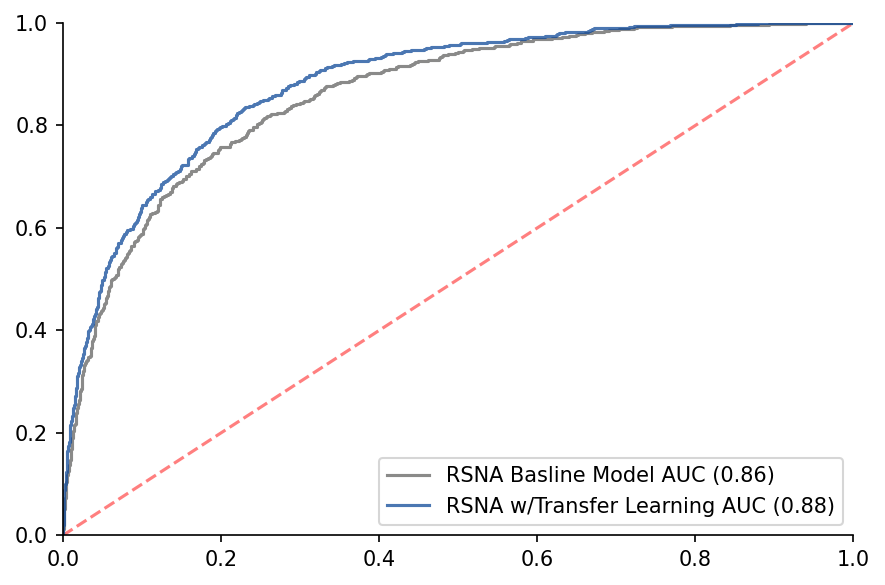

In [6]:
def plot_aurocs(save_path:str=None) -> None:
    fig = plt.figure(dpi=150)
    ax = fig.gca()
    
    ax.plot([0, 1], [0, 1], '--', color='red', alpha=.5)
    
    for label, col, color in [('RSNA Basline Model', 'rsna_baseline_proba', '#636362'), 
                              ('RSNA w/Transfer Learning', 'rsna_densenet_proba', '#0f4999')]:
        y_test, y_score = get_y_test_y_score(proba_col_name=col)
        tpr, fpr, _ = metrics.roc_curve(y_test, y_score)
        roc_auc = metrics.roc_auc_score(y_test, y_score)
        ax.plot(tpr, fpr, alpha=.75, color=color, label='{} AUC ({:.2f})'.format(label, roc_auc))
        
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower right')
    fig.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='png')
        
    plt.show()
    
plot_aurocs('/home/tstrebel/repos/umich-mads-capstone-project/figures/rsna-aurocs.png')

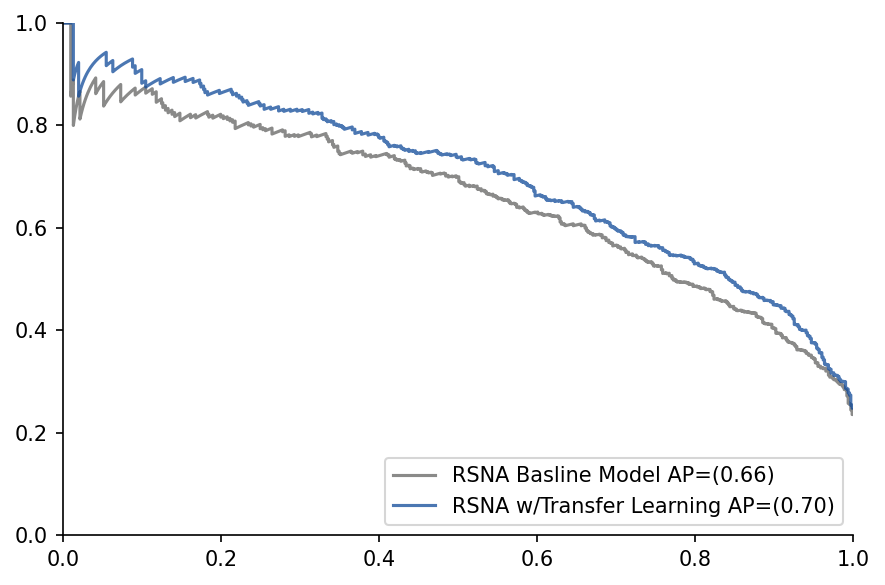

In [7]:
def plot_auprcs(save_path:str=None) -> None:
    fig = plt.figure(dpi=150)
    ax = fig.gca()
    
    for label, col, color in [('RSNA Basline Model', 'rsna_baseline_proba', '#636362'), 
                              ('RSNA w/Transfer Learning', 'rsna_densenet_proba', '#0f4999')]:
        y_test, y_score = get_y_test_y_score(proba_col_name=col)
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
        ap = metrics.average_precision_score(y_test, y_score)
        ax.plot(recall, precision, alpha=.75, color=color, label='{} AP=({:.2f})'.format(label, ap))
        
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower right')
    fig.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='png')
        
    plt.show()
    
plot_auprcs('/home/tstrebel/repos/umich-mads-capstone-project/figures/rsna-auprcs.png')